In [88]:
# %pip install moviepy pydub numpy scipy matplotlib

In [89]:
EXECUTION_MODE = 'LOCAL'  # LOCAL or COLAB

In [90]:
if EXECUTION_MODE == 'COLAB':
    from google.colab import files
    uploaded = files.upload()
    filename = next(iter(uploaded))
    print(filename)
else:
    filename = '../VideoAnalysis/videos/table_tennis_full.mp4' # Change this to the video file you want to process

In [91]:
print(filename)

videos/extracted-highlights.mp4


In [92]:
import moviepy.editor as mp
from pydub import AudioSegment
import numpy as np

# Step 1: Extract audio from video
video = mp.VideoFileClip(filename)
audio = video.audio
audio.write_audiofile(f"{filename}_audio.wav")

MoviePy - Writing audio in videos/extracted-highlights.mp4_audio.wav


MoviePy - Done.


In [93]:
# Step 2: Load audio and analyze decibel levels
audio_name = f"{filename}_audio.wav"
audio_segment = AudioSegment.from_file(audio_name)

In [100]:
# Function to calculate RMS value
def calculate_rms(frame):
    samples = np.array(frame.get_array_of_samples(), dtype=np.int32)
    return np.sqrt(np.mean(samples**2))

# Function to convert RMS to decibel
def rms_to_db(rms):
    if rms == 0:
      return 0
    return 20 * np.log10(rms)

# Calculate decibel levels for each frame
def calculate_videoDB(audio_segment, frame_count, segment_duration) -> np.ndarray:
    decibel_levels = []
    for i in range(frame_count):
        frame = audio_segment[i * segment_duration:(i + 1) * segment_duration]
        rms = calculate_rms(frame)
        db = rms_to_db(rms)
        decibel_levels.append(db)
    return np.array(decibel_levels)

frame_rate = video.fps
segment_duration = (1000 / frame_rate)
frame_count = int(len(audio_segment) / segment_duration)
total_second = frame_count / frame_rate
hightlight_cuts = 50
hightlight_sec = 60
hightlight_frames = int(hightlight_sec * frame_rate)
left_ratio = 0.6
right_ratio = 0.4
print(f"total seconds: {total_second}")
print(f"hightlight seconds: {hightlight_sec}")
print(f"hightlight frames: {hightlight_frames}")
print(f"total frames: {frame_count}")

total seconds: 6210.0038
hightlight seconds: 60
hightlight frames: 1798
total frames: 186114


In [101]:
decibel_levels = calculate_videoDB(audio_segment, frame_count, segment_duration)

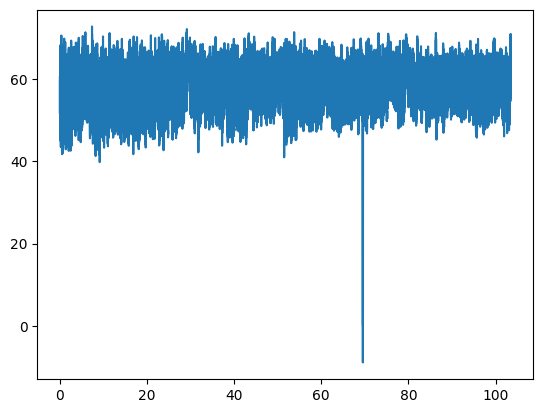

In [102]:
import matplotlib.pyplot as plt

xaxis = np.linspace(0, total_second / 60, frame_count)
plt.plot(xaxis, decibel_levels)

In [103]:
hightlights = []
def checkInHighlights(idx, hightlights: list):
    if len(hightlights) == 0:
        return False
    for start, end in hightlights:
        if start <= idx <= end:
            return True
    return False

def addHightlight(hightlight, hightlights: list):
    hightlights.append(hightlight)

def merge_hightlights(hightlights: list):
    idx = 0
    threshold = 1
    while idx < len(hightlights) - 1:
        start1, end1 = hightlights[idx]
        start2, end2 = hightlights[idx + 1]
        if start2 - end1 < threshold:
            hightlights[idx] = (start1, end2)
            hightlights.pop(idx + 1)
        else:
            idx += 1
            
ORDER = "descending"
if ORDER == "descending":
    # descending
    argsort_db = np.argsort(decibel_levels)[::-1]
else:
    # ascending
    argsort_db = np.argsort(decibel_levels)
idx = 0
while len(hightlights) < hightlight_cuts:
    in_highlights = checkInHighlights(argsort_db[idx], hightlights)
    if in_highlights:
        idx += 1
        continue
    hightlight = None
    # print(argsort_db[idx])
    if argsort_db[idx] < hightlight_frames*left_ratio:
        print("left side")
        hightlight = (0, hightlight_frames-1)
    elif argsort_db[idx] > frame_count - hightlight_frames*right_ratio:
        print("right side")
        hightlight = (frame_count - hightlight_frames, frame_count-1)
    else:
        print("middle")
        hightlight = (argsort_db[idx] - hightlight_frames*left_ratio, argsort_db[idx] + (hightlight_frames*right_ratio) - 1)
    # print(hightlight)
    hightlight = (int(hightlight[0]), int(hightlight[1]))
    addHightlight(hightlight, hightlights)
    idx += 1    
# divide the frame number by frame_rate to get the time in seconds
hightlights_in_seconds = [(int(start / frame_rate), int(end / frame_rate)) for start, end in hightlights]
hightlights_in_seconds = sorted(hightlights_in_seconds, key=lambda x: x[0])
# merge the hightlights if they are too close
merge_hightlights(hightlights_in_seconds)
print(hightlights_in_seconds)

middle
middle
middle
middle
middle
middle
middle
middle
middle
right side
middle
middle
middle
left side
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
[(0, 59), (119, 179), (223, 375), (406, 466), (557, 617), (647, 707), (755, 815), (817, 877), (927, 1086), (1093, 1153), (1217, 1509), (1655, 1814), (1819, 1879), (2108, 2168), (2359, 2419), (2506, 2624), (2639, 2699), (2894, 2980), (3073, 3133), (3190, 3250), (3285, 3395), (3539, 3599), (3609, 3669), (4010, 4070), (4106, 4166), (4214, 4274), (4351, 4411), (4485, 4545), (4647, 4707), (4733, 4792), (4885, 4945), (5142, 5202), (5617, 5677), (5722, 5782), (5947, 6007), (6150, 6209)]


In [104]:
# extract the hightlights from the video
highlight_clips = []
for start, end in hightlights_in_seconds:
    highlight_clips.append(video.subclip(start, end))

# concatenate the hightlights
highlight_video = mp.concatenate_videoclips(highlight_clips)
highlight_video.write_videofile(f"{filename}_highlight.mp4", codec="libx264")

Moviepy - Building video videos/extracted-highlights.mp4_highlight.mp4.
MoviePy - Writing audio in extracted-highlights.mp4_highlightTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video videos/extracted-highlights.mp4_highlight.mp4



Moviepy - Done !
Moviepy - video ready videos/extracted-highlights.mp4_highlight.mp4


In [105]:
import os
os.system(f"rm -f {filename}_audio.wav")

0